In [1]:
include("../src/cliff7.jl")
using PyPlot
using Random
using LinearAlgebra

In [92]:
function c2i(cor, shape)
    i, j = cor
    i -= 1
    j -= 1
    n1, n2 = shape
    idx = j * n1 + i
    return idx + 1
end


function i2c(idx, shape)
    n1, n2 = shape
    idx -= 1
    j = div(idx, n1)
    i = idx % n1
    return i + 1, j + 1
end


@views function preserve_X123_mat()
    bmat = zeros(Bool, 8, 8)
    for i in 1:6
        bmat[i, i] = true
    end
    for i in 1:3
        rand!(bmat[2i, 1:2:6])
        rand!(bmat[2i, 7:8])
        for j in 1:i-1
            if binary_symplectic_inner(bmat[2i, :], bmat[2j, :])
                bmat[2i, 2j-1] = xor(bmat[2i, 2j-1], true)
            end
        end
    end
    while all(bmat[7, :] .== false)
        rand!(bmat[7, 1:2:6])
        rand!(bmat[7, 7:8])
        for j in 1:3
            if binary_symplectic_inner(bmat[7, :], bmat[2j, :])
                bmat[7, 2j-1] = xor(bmat[7, 2j-1], true)
            end
        end
    end
    while all(bmat[8, :] .== false)
        while !binary_symplectic_inner(bmat[8, :], bmat[7, :])
            rand!(bmat[8, 1:2:6])
            rand!(bmat[8, 7:8])
        end
        for j in 1:3
            if binary_symplectic_inner(bmat[8, :], bmat[2j, :])
                bmat[8, 2j-1] = xor(bmat[8, 2j-1], true)
            end
        end
    end
    return bmat
end


function binary_z2gauge_mat()
    T = Bool[
        1 0 1 0 0 0 0 0;
        0 1 0 0 0 0 0 0;
        0 0 1 0 1 0 0 0;
        0 1 0 1 0 0 0 0;
        0 0 0 0 1 0 1 0;
        0 1 0 1 0 1 0 0;
        0 0 0 0 0 0 1 0;
        0 1 0 1 0 1 0 1]
    Ti = Bool[
         1  0  1  0  1  0  1  0;
         0  1  0  0  0  0  0  0;
         0  0  1  0  1  0  1  0;
         0  1  0  1  0  0  0  0;
         0  0  0  0  1  0  1  0;
         0  0  0  1  0  1  0  0;
         0  0  0  0  0  0  1  0;
         0  0  0  0  0  1  0  1]
    bmat = preserve_X123_mat()
    return isodd.(Ti*bmat*T)
end


function cliff_act_on_op!(cliff, op, sites)
    n = length(sites)
    @assert div(size(cliff, 1), 2) == n
    indices = zeros(Int, 2n)
    for i in 1:n
        indices[2i-1] = 2sites[i]-1
        indices[2i]   = 2sites[i]
    end
    sub_op = op[indices]
    
    op[indices] .= false
    for i in 1:2n
        if sub_op[i]
            for j in 1:2n
                op[indices[j]] ⊻= cliff[i, j]
            end
        end
    end
    
    return nothing
end


function gauge_randomly_update_a_square(op, shape)
    m, n = shape
    c1 = rand(1:2:m-2)
    c2 = rand(1:n-2)
    
    i1 = c2i((c1, c2), shape)
    i2 = c2i((c1+1, c2), shape)
    i3 = c2i((c1+1, c2+1), shape)
    i4 = c2i((c1+2, c2), shape)
    
    cliff = binary_z2gauge_mat()
    cliff_act_on_op!(cliff, op, [i1,i2,i3,i4])
    
    return nothing
end

function randomly_update_a_square(op, shape)
    m, n = shape
    c1 = rand(1:2:m-2)
    c2 = rand(1:n-2)
    
    i1 = c2i((c1, c2), shape)
    i2 = c2i((c1+1, c2), shape)
    i3 = c2i((c1+1, c2+1), shape)
    i4 = c2i((c1+2, c2), shape)
    
    cliff = binary_random_symplectic_matrix(4)
    cliff_act_on_op!(cliff, op, [i1,i2,i3,i4])
    
    return nothing
end

function update_a_square(cor, op, shape)
    m, n = shape
    c1, c2 = cor
    
    i1 = c2i((c1, c2), shape)
    i2 = c2i((c1+1, c2), shape)
    i3 = c2i((c1+1, c2+1), shape)
    i4 = c2i((c1+2, c2), shape)
    
    cliff = binary_z2gauge_mat()
    cliff_act_on_op!(cliff, op, [i1,i2,i3,i4])
    
    return nothing
end


function loop_in_the_middle(m, n)
    shape = m, n
    c1 = div(m, 2)
    if iseven(c1)
        c1 = c1+1
    end
    c2 = div(n, 2)
    
    op = zeros(Bool, m*n*2)
    
    i1 = c2i((c1, c2), shape)
    i2 = c2i((c1+1, c2), shape)
    i3 = c2i((c1+1, c2+1), shape)
    i4 = c2i((c1+2, c2), shape)
    
    op[2i1] = op[2i2] = op[2i3] = op[2i4] = true
    return op
end  
    
    

function draw_an_op(ax, op, shape, cmap)
    m, n = shape
    @assert m*n==length(op)
    
    for i in 1:m
        for j in 1:n
            idx = c2i((i,j), shape)
            if isodd(i)
                ax.plot([j-1, j], [-div(i-1, 2), -div(i-1, 2)], c=cmap[Int(op[idx])+1])
            else
                ax.plot([j-1, j-1], [-div(i-1, 2), -div(i-1, 2)-1], c=cmap[Int(op[idx])+1])
            end
        end
    end
    return nothing
end    

draw_an_op (generic function with 1 method)

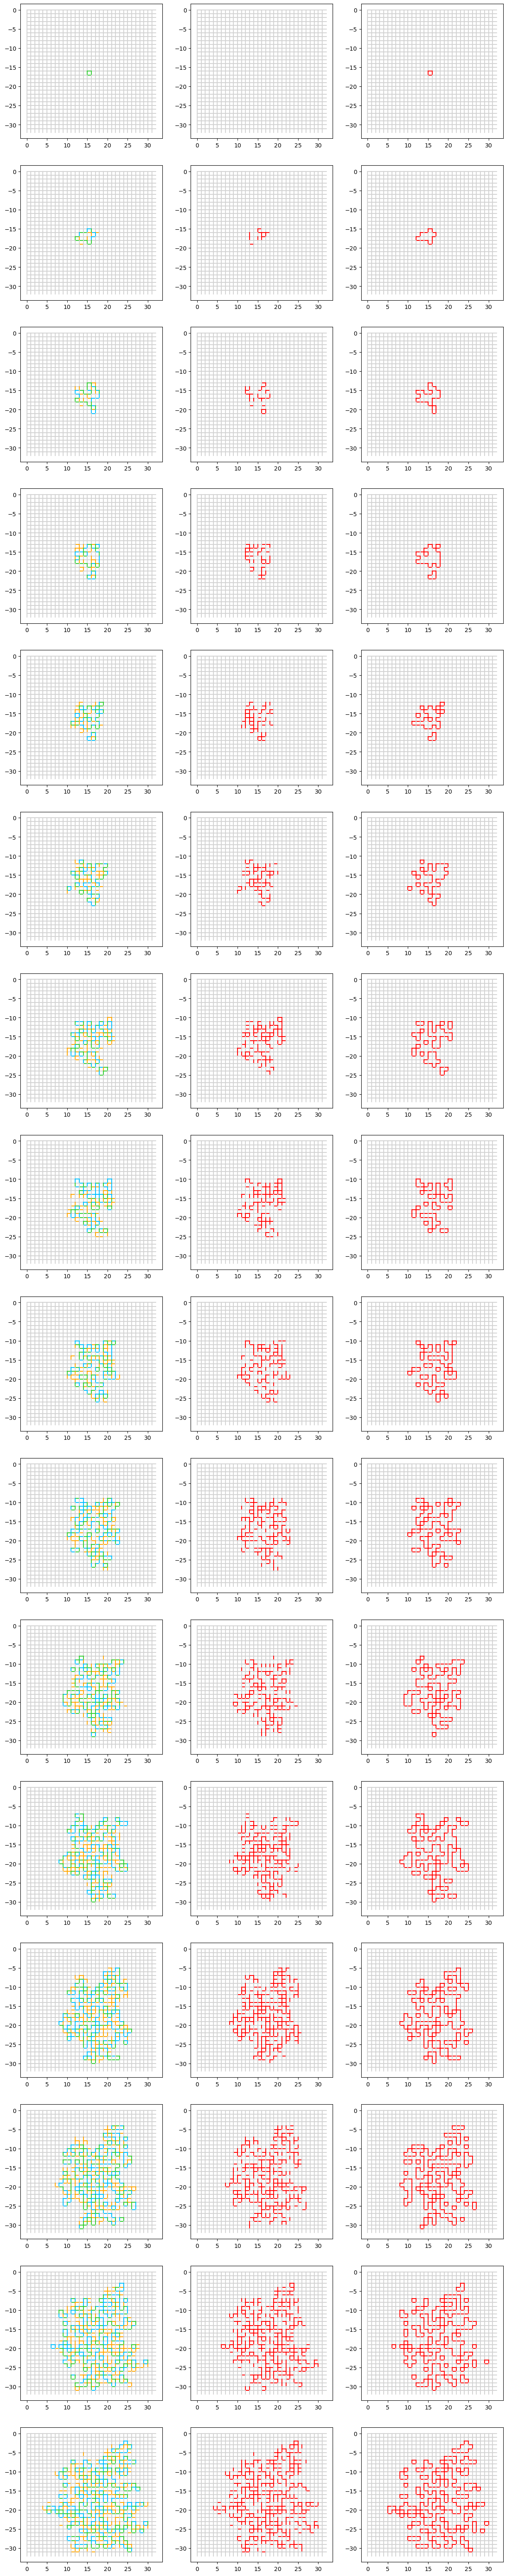

In [93]:
begin
    m = 64
    n = 32
    n_step = 16

    shape = (m, n)

    fg,axs = subplots(n_step, 3, figsize=(15, n_step*5))


    op = loop_in_the_middle(m, n)
    for k in 1:n_step
        draw_an_op(axs[k,1], op[1:2:end] .+ 2 .* op[2:2:end], shape, ["lightgrey","orange", "limegreen", "deepskyblue"])
        draw_an_op(axs[k,2], op[1:2:end], shape, ["lightgrey","red"])
        draw_an_op(axs[k,3], op[2:2:end], shape, ["lightgrey","red"])
        for _ in 1:div(m*n,4)
            gauge_randomly_update_a_square(op, shape)
        end
    end

    fg.savefig("z2_opspread.png")
end

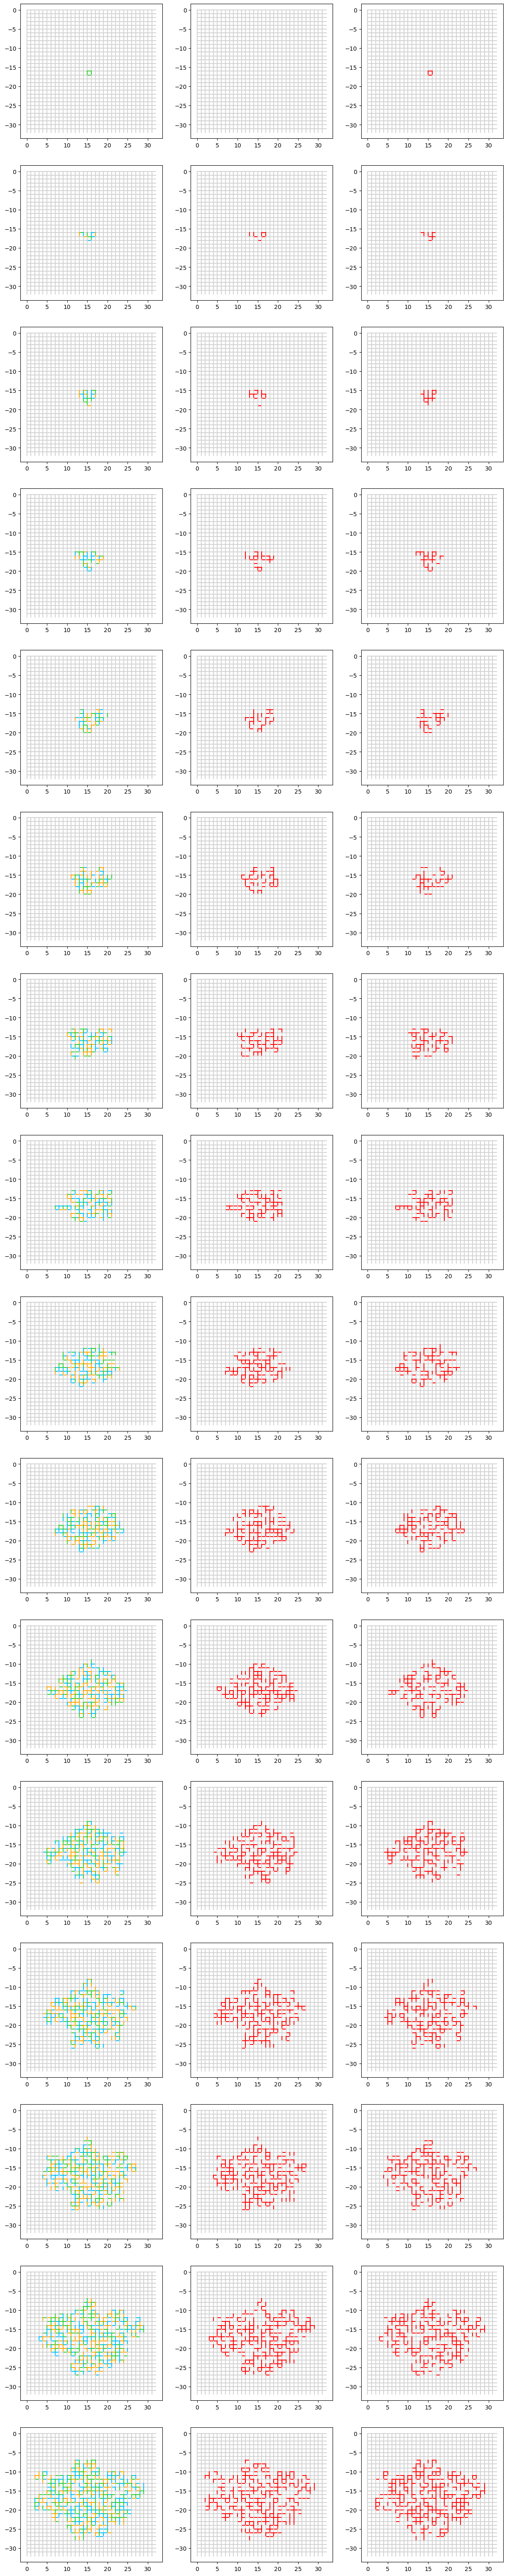

In [94]:
begin
    m = 64
    n = 32
    n_step = 16

    shape = (m, n)

    fg,axs = subplots(n_step, 3, figsize=(15, n_step*5))


    op = loop_in_the_middle(m, n)
    for k in 1:n_step
        draw_an_op(axs[k,1], op[1:2:end] .+ 2 .* op[2:2:end], shape, ["lightgrey","orange", "limegreen", "deepskyblue"])
        draw_an_op(axs[k,2], op[1:2:end], shape, ["lightgrey","red"])
        draw_an_op(axs[k,3], op[2:2:end], shape, ["lightgrey","red"])
        for _ in 1:div(m*n,4)
            randomly_update_a_square(op, shape)
        end
    end

    fg.savefig("opspread.png")
end

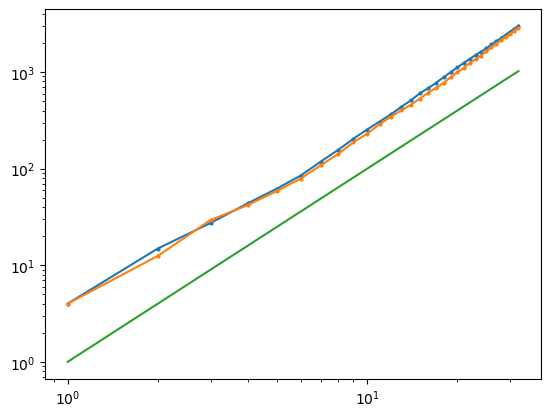

In [105]:
begin
    m = 128
    n = 64
    n_step = 32
    avg = 10
    
    result1 = zeros(n_step)
    result2 = zeros(n_step)

    shape = (m, n)
    
    for _ in 1:avg
        op = loop_in_the_middle(m, n)
        for k in 1:n_step
            result1[k] += sum(op)
            for _ in 1:div(m*n,4)
                gauge_randomly_update_a_square(op, shape)
            end
        end
    end
    
    
    for _ in 1:avg
        op = loop_in_the_middle(m, n)
        for k in 1:n_step
            result2[k] += sum(op)
            for _ in 1:div(m*n,4)
                randomly_update_a_square(op, shape)
            end
        end
    end
    
    result1 ./= avg
    result2 ./= avg
    
    plot(1:n_step, result1, "-o", ms=2)
    plot(1:n_step, result2, "-o", ms=2)
    
    t = 1:n_step
    plot(t, t.^2)
    xscale("log")
    yscale("log")
end